# Virtual Acoustic Environments Spring 2022
## Project 9: Headphone Equalization using the Mean Square Error
**Author: Alpar Gür**

**Supervisor: David Bau**

**Professor: Christoph Pörschmann**

---

In [1]:
# import packages
import numpy as np
import sounddevice as sd
import soundfile as sf

from collections import defaultdict
from numpy import pi, abs, log10, ndarray, append, conj, convolve, roll
from numpy.fft import fft, ifft
from scipy.signal import butter, firwin, firwin2, unit_impulse, sosfilt, kaiserord, freqz
from shared.record_signal import convert_audio_to_numpy_array, play_sound
import matplotlib.pyplot as plt

import IPython.display as ipd

In [2]:
# define global parameters
fs = 44100
nyquist = fs / 2.0
n = 17640
n_one_sided = int(n / 2 + 1)
recording_count = 10
headphones = ['HD600', 'K601_001918']

### Get Headphone Recordings

Get Impulse Response (IR) for each Headphone

In [3]:
def get_impulse_response_in_time_domain(headphone: str, i: int, n: int = 17640):
    audio, fs = convert_audio_to_numpy_array(f"../HPIRs_Erbes_44100Hz/Measurements/{headphone}/pass0{i}.wav")
    return audio

In [4]:
headphone_impulse_responses = defaultdict(dict)

for i in range(len(headphones)):
    key = headphones[i]
    print(f"Headphone:\t {key}")
    for inner_key in range(recording_count):
        headphone_impulse_responses[key][inner_key] = get_impulse_response_in_time_domain(key, inner_key, n)
    shape = headphone_impulse_responses[key][recording_count-1].shape
    print(f'Shape:\t\t {shape}')

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Get Fourier Transform of IRs for each Headphone

In [5]:
def transform_impulse_responses_to_frequency_domain(recording):
    y_l = recording[:, 0]
    y_r = recording[:, 1]
    Y_L = fft(y_l)
    Y_R = fft(y_r)
    Y = append([Y_L], [Y_R], axis=0)
    Y = Y.transpose()
    return Y

In [6]:
headphone_impulse_responses_fft = defaultdict(dict)

for i in range(len(headphones)):
    key = headphones[i]
    print(f"Headphone:\t {key}")
    for inner_key in range(recording_count):
        headphone_impulse_responses_fft[key][inner_key] = transform_impulse_responses_to_frequency_domain(headphone_impulse_responses[key][inner_key])
    shape = headphone_impulse_responses_fft[key][recording_count-1].shape
    print(f'Shape:\t\t {shape}')

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Compute Complex Mean of Time Domain IRs for each Headphone

In [7]:
def get_complex_mean(audios, recording_count, n: int = 17640):
    Y_L_sum = np.empty([n])
    Y_R_sum = np.empty([n])

    for inner_key in range(recording_count):
        Y_L_sum = Y_L_sum + audios[inner_key][:, 0]
        Y_R_sum = Y_R_sum + audios[inner_key][:, 1]

    Y_L_complex_mean = Y_L_sum / recording_count
    Y_R_complex_mean = Y_R_sum / recording_count
    Y_complex_mean = append([Y_L_complex_mean], [Y_R_complex_mean], axis = 0)
    Y_complex_mean = Y_complex_mean.transpose()

    return Y_complex_mean

In [8]:
headphone_complex_means = defaultdict(dict)

for i in range(len(headphones)):
    key = headphones[i]
    print(f"Headphone:\t {key}")
    headphone_complex_means[key] = get_complex_mean(headphone_impulse_responses_fft[key], recording_count, n)
    shape = headphone_complex_means[key].shape
    print(f'Shape:\t\t {shape}')


Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Visualize Spectrum

In [9]:
def viz_spectrum(recording, n, ax1_title, ax2_title, title, fs=44100):
    f_vec = np.linspace(0, fs/2, n)
    left_channel = recording[:, 0][: n]
    right_channel = recording[:, 1][: n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)

    ax1.set_xlabel("Frequency [Hz]")
    ax2.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Magnitude (dB)")

    ax1.semilogx(f_vec, 20*log10(abs(left_channel)))
    ax2.semilogx(f_vec, 20*log10(abs(right_channel)))

    ax1.set_xlim([20, fs/2])
    ax1.set_ylim(-60, 30)
    ax2.set_xlim([20, fs/2])
    ax2.set_ylim(-60, 30)

    ax1.grid(True)
    ax2.grid(True)

    fig.suptitle(title)
    fig.show()

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/41350975.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


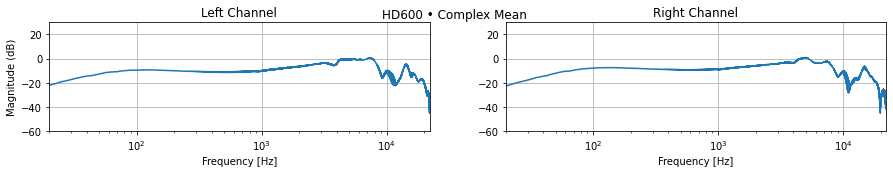

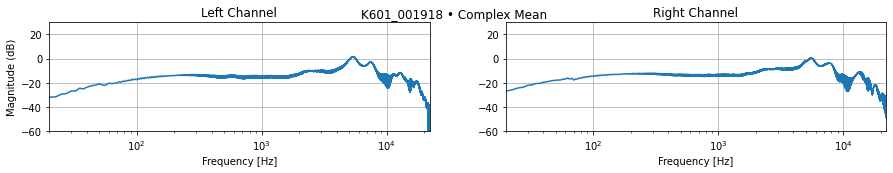

In [10]:
for headphone in headphones:
    viz_spectrum(headphone_complex_means[headphone], n_one_sided, 'Left Channel', 'Right Channel', f'{headphone} • Complex Mean')

### Design Bandpass Filter

Bandpass Filter with Kaiser Windowing

In [11]:
# bandpass filter with kaiser window
lowcut_freq = 20.0 / nyquist
highcut_freq =20000.0 / nyquist
# desired width of the transition from pass to stop, relative to the Nyquist rate
width = 5.0 / nyquist
# desired attenuation in the stop band, in dB
ripple_db = 60.0
# compute the order and Kaiser parameter for the FIR filter
N, beta = kaiserord(ripple_db, width)
# cutoff frequency of the filter
cutoff_hz = 20.0
beta_kaiser = .1102*(ripple_db-8.7);

kaiser_taps = firwin(n+1, [lowcut_freq, highcut_freq], window=('kaiser', beta_kaiser), pass_zero='bandpass')
# convert to frequency domain
KAISER_TAPS = fft(kaiser_taps, n)

In [12]:
def viz_filter(taps, n, filter_name):
    w, h = freqz(taps, worN=n)

    plt.plot((w/pi)*nyquist, abs(h), linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.ylim(-0.05, 1.05)
    plt.title(f'Frequency Response of {filter_name}')
    plt.grid(True)
    plt.show()

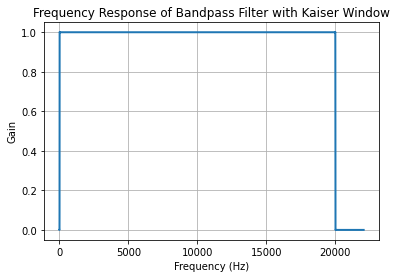

In [13]:
viz_filter(kaiser_taps, n, 'Bandpass Filter with Kaiser Window')

FIR Bandpass Filter by pushing a Dirac Impulse through a Buttersworth SOS 

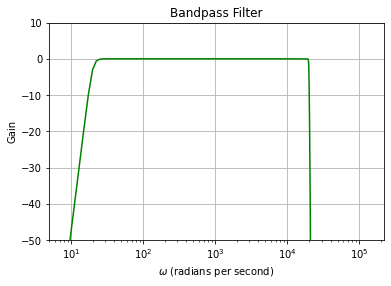

In [90]:
# filter parameters
highcut = 20000 
low_order = 8
lowcut = 20
high_order = 8

low_pass_filter = high_pass_filter = unit_impulse(n)

# lowpass
sos_low_pass = butter(low_order, highcut, 'lowpass', fs=fs, output='sos')
low_pass_filter = sosfilt(sos_low_pass, low_pass_filter)
low_pass_filter = fft(low_pass_filter)

# highpass
sos_hp = butter(high_order, lowcut, 'highpass', fs=fs, output='sos')
high_pass_filter = sosfilt(sos_hp, high_pass_filter)
high_pass_filter = fft(high_pass_filter)

bandlimit_filter = high_pass_filter * low_pass_filter

#plot
f_vec = np.linspace(0, fs/2, n_one_sided)
plt.semilogx(f_vec, 20*log10(abs(bandlimit_filter[: n_one_sided])), color='green')
plt.xlim([10/2, fs/2*10])
plt.ylim([-50, 10])

plt.xlabel('$\omega$ (radians per second)')
plt.ylabel('Gain')
plt.title('Bandpass Filter')
plt.grid(True)

### Design Regularisation Filter

In [91]:
taps = 51
freqs = [0, 0.2, 0.6, 1]
gain = np.array([-20, -20, 0, 0]).astype(float)
linear_gain = 10**(gain/20)
#linear_gain[-1] = 0

b = firwin2(taps, freqs, linear_gain, window=('kaiser', 8))
B = fft(b, n)

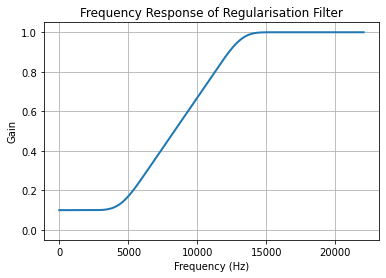

In [92]:
viz_filter(b, n, 'Regularisation Filter')

### Calculate Inverse Filter in Frequency Domain

$hc = [H^{T}H + \beta B^{T}B] * H^{T}d$

$H_c(k) = \frac{D^{*}(k)H(k)}{H(k)H^{*}(k) + \beta \cdot B(k)B^{*}(k)}$

- $hc$ -> convolution matrice of measured transfer function
- $H$ -> convolution matrice of measured regularisation filter
- $B$ -> signal vector 
- $d$ -> signal vector (latter denoting the delayed IR of target bandpass filter)
- $\beta$ -> weighting regularisation filter

In [93]:
def filter_inverse(input_signal, bandpass_filter, regularisation_filter, beta: float = 0.4):
    Hc_L = bandpass_filter.transpose() * conj(input_signal[:, 0]).transpose() / \
        (input_signal[:, 0].transpose() * conj(input_signal[:, 0]) + beta * regularisation_filter.transpose() * conj(regularisation_filter.transpose()))
    Hc_R = bandpass_filter.transpose() * conj(input_signal[:, 1]).transpose() / \
        (input_signal[:, 1].transpose() * conj(input_signal[:, 1]) + beta * regularisation_filter.transpose() * conj(regularisation_filter.transpose()))
    output = np.append([Hc_L], [Hc_R], axis = 0)
    output = output.transpose()
    print(f"Shape:\t\t {output.shape}")

    return output

In [94]:
# using bandpass filter with Kaiser window
headphone_inversed_complex_means_kaiser = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {key}")
    headphone_inversed_complex_means_kaiser[key] = filter_inverse(headphone_complex_means[key], KAISER_TAPS, B, beta=0.4)

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


In [95]:
# with buttersworth bandpass filter
headphone_inversed_complex_means_buttersworth = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {key}")
    headphone_inversed_complex_means_buttersworth[key] = filter_inverse(headphone_complex_means[key], bandlimit_filter, B, beta=0.1)

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


Visualize Signals Processed through Compensation Filter for each Headphone

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/41350975.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


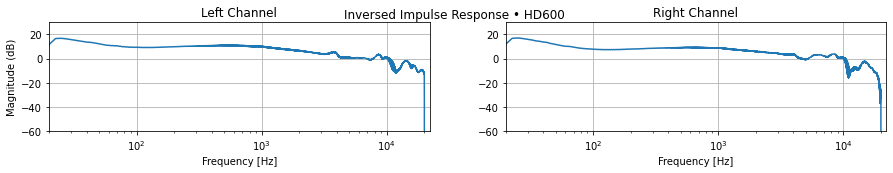

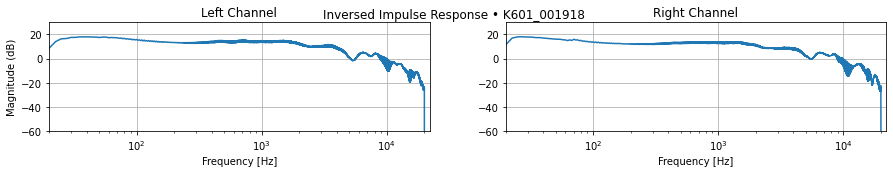

In [96]:
for headphone in headphones:
    key = headphone
    viz_spectrum(headphone_inversed_complex_means_kaiser[key], n_one_sided, 'Left Channel', 'Right Channel', f'Inversed Impulse Response • {headphone}')

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/41350975.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


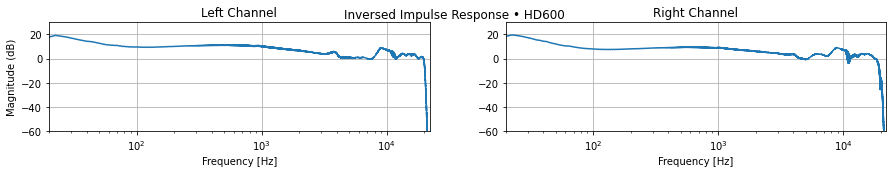

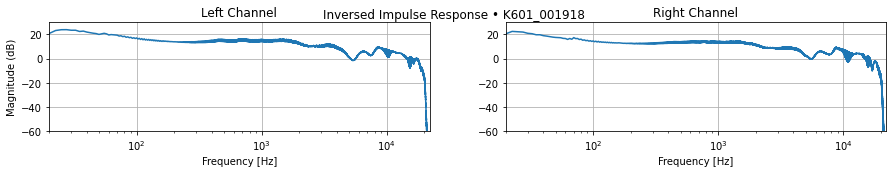

In [97]:
for headphone in headphones:
    key = headphone
    viz_spectrum(headphone_inversed_complex_means_buttersworth[key], n_one_sided, 'Left Channel', 'Right Channel', f'Inversed Impulse Response • {headphone}')

Transfer Back to Time Domain

In [98]:
def transfer_inverse_function_to_time_domain(input_signal):
    hc_l = ifft(input_signal[:, 0])
    hc_r = ifft(input_signal[:, 1])
    hc = np.append([hc_l], [hc_r], axis=0)
    hc = hc.transpose()
    return hc

In [99]:
# for kaiser window
headphone_compensated_ir_kaiser = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {headphone}")
    headphone_compensated_ir_kaiser[key] = transfer_inverse_function_to_time_domain(headphone_inversed_complex_means_kaiser[key])
    print(f"Shape:\t\t {headphone_compensated_ir_kaiser[key].shape}")

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


In [100]:
# for kaiser buttersworth
headphone_compensated_ir_buttersworth = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {headphone}")
    headphone_compensated_ir_buttersworth[key] = transfer_inverse_function_to_time_domain(headphone_inversed_complex_means_buttersworth[key])
    print(f"Shape:\t\t {headphone_compensated_ir_buttersworth[key].shape}")

Headphone:	 HD600
Shape:		 (17640, 2)
Headphone:	 K601_001918
Shape:		 (17640, 2)


In [101]:
def viz_impulse_response(signal, n, ax1_title, ax2_title, title, fs: int = 44100):
    t_vec = np.arange(0, n) / fs
    left_channel = signal[:, 0][:n]
    right_channel = signal[:, 1][:n]

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5), sharex='row', sharey='row')
    

    ax1.set_title(ax1_title)
    ax1.set_xlabel('Seconds')
    ax1.set_ylabel("Amplitude")


    ax2.set_title(ax2_title)
    ax2.set_xlabel('Seconds')
    ax2.set_ylabel("Amplitude")

    ax1.plot(t_vec, left_channel)
    ax2.plot(t_vec, right_channel)

    fig.suptitle(title, fontsize=16)

    ax1.grid(True)
    ax2.grid(True)
    fig.show()

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


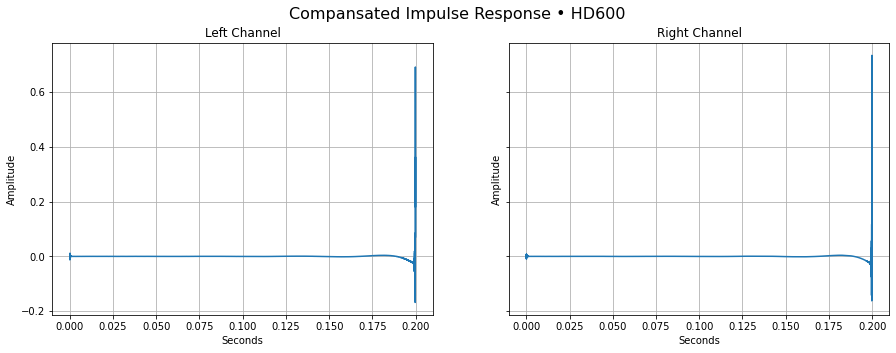

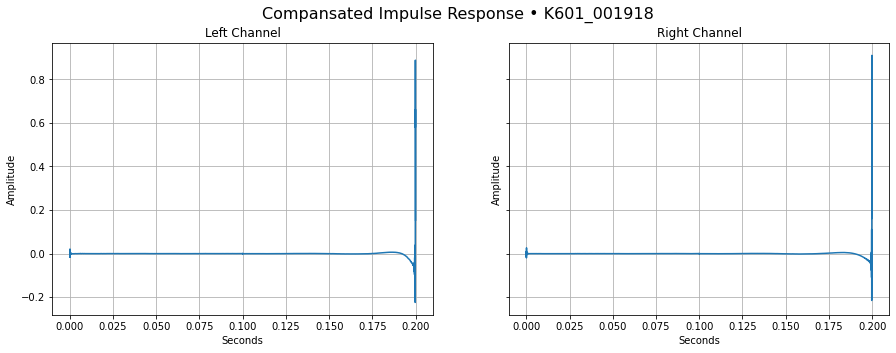

In [102]:
for headphone in headphones:
    key = headphone
    viz_impulse_response(headphone_compensated_ir_kaiser[key], n_one_sided, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


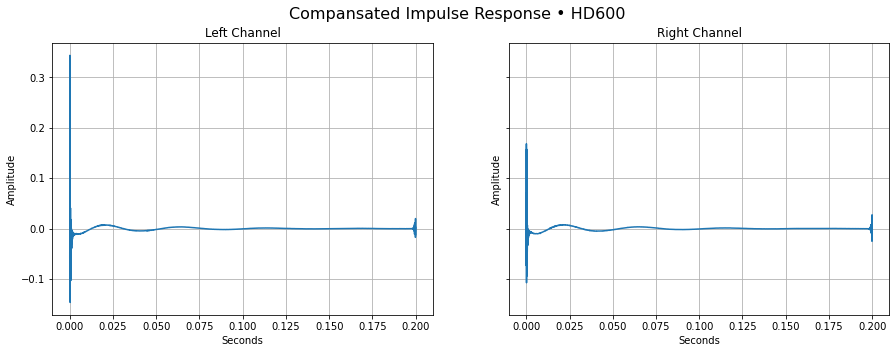

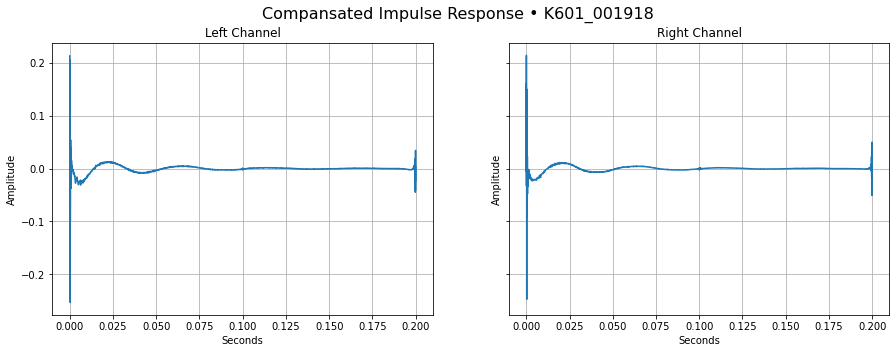

In [103]:
for headphone in headphones:
    key = headphone
    viz_impulse_response(headphone_compensated_ir_buttersworth[key], n_one_sided, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

Shift Signal and Cut Delay

In [104]:
def shift_and_cut_signal(input_signal, roll_distance, n):
    rolled_signal = roll(input_signal, roll_distance)
    shifted_signal_l = rolled_signal[:, 0][:n]
    shifted_signal_r = rolled_signal[:, 1][:n]
    output = append([shifted_signal_l], [shifted_signal_r], axis = 0)
    output = output.transpose()
    print(f'Shape:\t\t {output.shape}')
    return output


In [105]:
headphone_shifted_compensated_ir_kaiser = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f'Headphone:\t {headphone}')
    headphone_shifted_compensated_ir_kaiser[key] = shift_and_cut_signal(headphone_compensated_ir_kaiser[key], int(n+160), n_one_sided)

Headphone:	 HD600
Shape:		 (8821, 2)
Headphone:	 K601_001918
Shape:		 (8821, 2)


/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


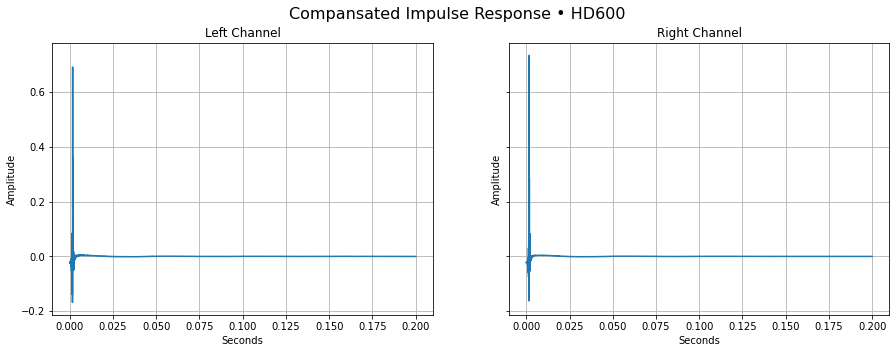

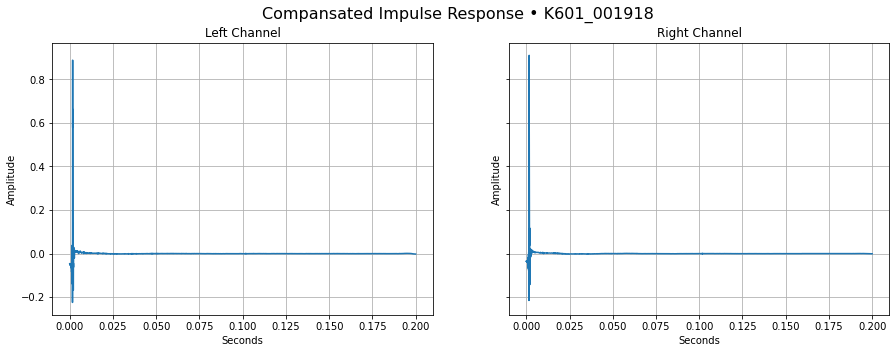

In [106]:
for headphone in headphones:
    key = headphone
    viz_impulse_response(headphone_shifted_compensated_ir_kaiser[key], n_one_sided, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

In [107]:
headphone_shifted_compensated_ir_buttersworth = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f'Headphone:\t {headphone}')
    headphone_shifted_compensated_ir_buttersworth[key] = shift_and_cut_signal(headphone_compensated_ir_buttersworth[key], int(160), n_one_sided)

Headphone:	 HD600
Shape:		 (8821, 2)
Headphone:	 K601_001918
Shape:		 (8821, 2)


/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/491829305.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


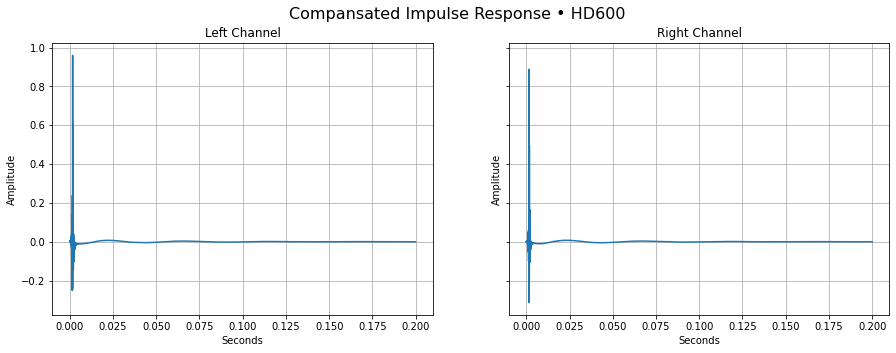

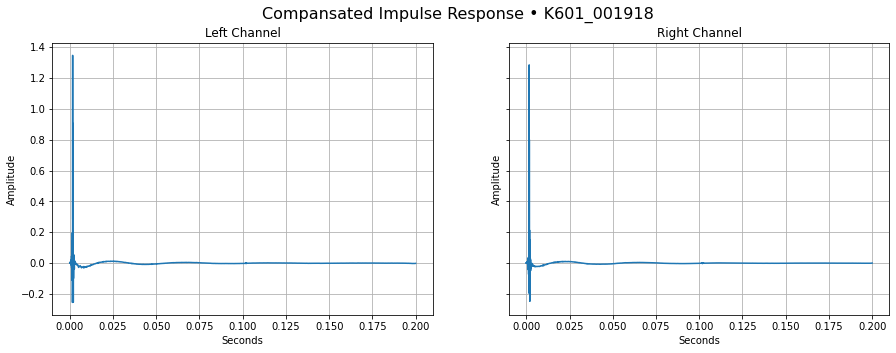

In [108]:
for headphone in headphones:
    key = headphone
    viz_impulse_response(headphone_shifted_compensated_ir_buttersworth[key], n_one_sided, 'Left Channel', 'Right Channel', f'Compansated Impulse Response • {headphone}')

### Test the Filters

In [109]:
# import a drum loop
drum_loop, drum_fs = convert_audio_to_numpy_array(f"../sounds/loops/drum_loop_128_bpm.wav")
print(f'Shape:\t\t {drum_loop.shape}')
print(f'Sample Rate:\t {drum_fs}')

Shape:		 (330750, 2)
Sample Rate:	 44100


In [110]:
def convolve_sample_with_impulse_response(sample, impulse_response, fs):
    left_channel  = convolve(sample[:, 0], impulse_response[:, 0])
    right_channel  = convolve(sample[:, 1], impulse_response[:, 1])

    output = np.append([left_channel], [right_channel], axis = 0)
    output = output.transpose()
    output = output.astype('float32')

    return output

In [111]:
drum_loop_filtered_kaiser = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {headphone}")
    drum_loop_filtered_kaiser[key] = convolve_sample_with_impulse_response(drum_loop, headphone_shifted_compensated_ir_kaiser[key], drum_fs)
    print(f"Shape:\t\t {drum_loop_filtered_kaiser[key].shape}")

Headphone:	 HD600


/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/148840766.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  output = output.astype('float32')


Shape:		 (339570, 2)
Headphone:	 K601_001918
Shape:		 (339570, 2)


In [112]:
drum_loop_filtered_buttersworth = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {headphone}")
    drum_loop_filtered_buttersworth[key] = convolve_sample_with_impulse_response(drum_loop, headphone_shifted_compensated_ir_buttersworth[key], drum_fs)
    print(f"Shape:\t\t {drum_loop_filtered_buttersworth[key].shape}")

Headphone:	 HD600


/var/folders/q_/_sb8ml5x6px7zxlxs9cnf9jc0000gn/T/ipykernel_87600/148840766.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  output = output.astype('float32')


Shape:		 (339570, 2)
Headphone:	 K601_001918
Shape:		 (339570, 2)


In [113]:
# import filters of erbes
def import_filter_of_erbes(path):
    filter, fs = convert_audio_to_numpy_array(path)
    return filter

In [114]:
erbes_filters = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {headphone}")
    erbes_filters[key] = import_filter_of_erbes(f"../HPIRs_Erbes_44100Hz/compensation_filters/hpComp_{headphone}_1Filter.wav")
    print(f'Shape:\t\t {erbes_filters[key].shape}')

Headphone:	 HD600
Shape:		 (2048, 2)
Headphone:	 K601_001918
Shape:		 (2048, 2)


In [115]:

drum_loop_filtered_erbes = defaultdict(dict)

for headphone in headphones:
    key = headphone
    print(f"Headphone:\t {headphone}")
    drum_loop_filtered_erbes[key] = convolve_sample_with_impulse_response(drum_loop, erbes_filters[key], drum_fs)
    print(f'Shape:\t\t {drum_loop_filtered_erbes[key].shape}')

# WHY IS ERBES FILTER OUTPUT SHORTER ?

Headphone:	 HD600
Shape:		 (332797, 2)
Headphone:	 K601_001918
Shape:		 (332797, 2)


### Listen to Audios

Headphone: HD600

In [116]:
erbes_hd600 = drum_loop_filtered_erbes['HD600']
kaiser_hd600 = drum_loop_filtered_kaiser['HD600']
buttersworth_hd600 = drum_loop_filtered_buttersworth['HD600']

In [41]:
# original audio
play_sound(drum_loop, drum_fs)

In [124]:
play_sound(erbes_hd600, drum_fs)

In [121]:
play_sound(kaiser_hd600/2, drum_fs)

In [125]:
play_sound(buttersworth_hd600/3, drum_fs)

Headphone: K601_001918

In [ ]:
erbes_k601 = drum_loop_filtered_erbes['K601_001918']
kaiser_k601 = drum_loop_filtered_kaiser['K601_001918']
buttersworth_k601 = drum_loop_filtered_buttersworth['K601_001918']

In [ ]:
play_sound(erbes_k601, drum_fs)

In [ ]:
play_sound(kaiser_k601/2, drum_fs)

In [ ]:
play_sound(buttersworth_k601/2, drum_fs)